In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from matplotlib import pyplot
import numpy as np
from torch.utils.data import random_split
from torchvision import models,datasets
import os

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [3]:
data_dir = '../input/dogs-cats-images/dataset/training_set'
classes = os.listdir(data_dir)
print(classes)

['cats', 'dogs']


In [4]:
train_transform = transforms.Compose([
    transforms.Resize(96),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
test_transform = transform_test = transforms.Compose([
        transforms.Resize(96),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
working_ds = datasets.ImageFolder(root = os.path.join(data_dir),transform = train_transform)
train_ds,val_ds = random_split(working_ds,[7500,500])

train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=32, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_ds,
                                          batch_size=32, 
                                          shuffle=False)

In [6]:
i = 0
for images,labels in train_loader:
    print(images.shape)
    i = i+1
    if i == 10:
        break

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])


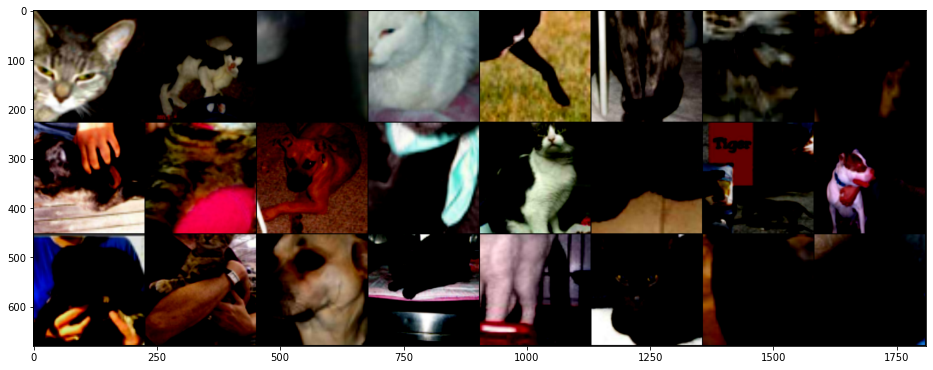

In [7]:
import matplotlib.pyplot as plt
import numpy
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [16]:
fe = models.resnet18(pretrained=True)
for param in fe.parameters():
	param.requires_grad = False

class ResNet18(nn.Module):
  def __init__(self):
    super(ResNet18, self).__init__()
    self.features = torch.nn.Sequential(*list(fe.children())[:-1])
    
    self.drop1 = nn.Dropout(0.3)
    self.fc1 = nn.Linear(512,256)
    self.drop2 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,2)
    
  def forward(self,x):
    x = self.features(x)
    
    x = x.view(x.shape[0],512)
    
    x = self.drop1(x)
    x = F.relu(self.fc1(x))
    x = self.drop2(x)
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    
    
    return x
    
#resnet_model = ResNet18()
#r = torch.nn.Sequential(*list(fe.children())[:-1])
#print(r)
r = ResNet18()
r = r.to(device)
print(r)

ResNet18(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [17]:
def model_eval(dataloader,model):
    total = 0
    correct = 0
    for data in dataloader:
      images, l = data
      
      images = images.to(device)
      l = l.to(device)
      
      out = r(images)
      max_val, preds = torch.max(out,dim=1)
      
      total += l.shape[0]                   
      correct += (preds == l).sum().item()  
      accuracy = (100 * correct)/total
    
    
    return accuracy

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(r.parameters(), lr=0.002, amsgrad=True)

In [ ]:
for epoch in range(10):
  print("Epoch:",epoch+1)
  running_loss = 0.0
  for i,data in enumerate(train_loader,0):
    inputs,labels = data
    
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    
    output = r(inputs)
    output = output.to(device)
    loss = criterion(output, labels)
    
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    
    if i % 100 == 99:    
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
      running_loss = 0.0
  
  print("EPOCH OVER")
  train_acc = model_eval(train_loader,r)
  test_acc = model_eval(val_loader,r)
  print("############################")
  print("Training Accuracy:",train_acc,"Testing Accuracy",test_acc)
  print("############################")
  print("")

Epoch: 1
[1,   100] loss: 0.279
[1,   200] loss: 0.294
EPOCH OVER
############################
Training Accuracy: 88.33333333333333 Testing Accuracy 89.0
############################

Epoch: 2
[2,   100] loss: 0.272
[2,   200] loss: 0.280
EPOCH OVER
############################
Training Accuracy: 88.33333333333333 Testing Accuracy 90.0
############################

Epoch: 3
[3,   100] loss: 0.274
[3,   200] loss: 0.277
EPOCH OVER
############################
Training Accuracy: 88.16 Testing Accuracy 87.6
############################

Epoch: 4
[4,   100] loss: 0.279
[4,   200] loss: 0.261
EPOCH OVER
############################
Training Accuracy: 88.18666666666667 Testing Accuracy 89.2
############################

Epoch: 5
[5,   100] loss: 0.277
[5,   200] loss: 0.256
EPOCH OVER
############################
Training Accuracy: 87.10666666666667 Testing Accuracy 86.0
############################

Epoch: 6
[6,   100] loss: 0.261
[6,   200] loss: 0.261
EPOCH OVER
##########################